# INFO2049 Image Captioning (NLP + Vision) - December 2025

- Camille Trinh s192024
- Lei Yang s201670
- Simon Gardier s192580

## Imports

In [1]:
from torch.utils.data import Dataset
from transformers import AutoTokenizer
from torchvision import transforms, models
from textwrap import wrap
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
import torch
import itertools
import json
import ast
import ssl
import sys
import os
print("import started")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
ssl._create_default_https_context = ssl._create_unverified_context
print("import halfway")

print("import finished")

import started
import halfway
import finished


## Utils

In [2]:
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return image


def show_image(image, title=None):
    plt.imshow(image)
    if title:
        plt.title("\n".join(wrap(title, 60)))
    plt.axis('off')
    plt.show()


def show_image_with_label(df, path_image_folder):
    for i in range(len(df)):
        image_name = df.iloc[i]['image']
        caption = df.iloc[i]['caption']
        image_path = os.path.join(path_image_folder, image_name)
        image = load_image(image_path)
        show_image(image, title=caption)


def analyze_image_splits(df):
    total_unique = df['image'].nunique()
    print(f"Total Unique Images: {total_unique}")

    split_counts = df.groupby('split')['image'].nunique()
    print(split_counts)

    if split_counts.sum() != total_unique:
        print(
            f"(WARNING: Sum of splits {split_counts.sum()} != Total images {total_unique})")

    splits = df['split'].unique()
    split_img_sets = {s: set(df[df['split'] == s]['image']) for s in splits}

    leaks_found = False
    for s1, s2 in itertools.combinations(splits, 2):
        intersection = split_img_sets[s1].intersection(split_img_sets[s2])
        if len(intersection) > 0:
            print(
                f"WARNING: Found {len(intersection)} images appearing in both '{s1}' and '{s2}'")
            leaks_found = True


def load_karpathy_dataframe(json_path, image_folder_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    rows = []
    for img_item in data['images']:
        filename = img_item['filename']
        split = img_item['split']
        for sentence in img_item['sentences']:
            caption = sentence['raw']
            rows.append({
                'image': filename,
                'image_path': os.path.join(image_folder_path, filename),
                'caption': caption.replace('\n', ' ').replace('\r', ' ').strip(),
                'split': split
            })

    return pd.DataFrame(rows)


class FlickrDataset(Dataset):
    def __init__(self, df, root, tokenizer, transform, max_length=30):
        super().__init__()
        self.df = df
        self.root = root
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df.iloc[idx]['image']
        caption_text = self.df.iloc[idx]['caption']
        image_path = os.path.join(self.root, image_name)
        try:
            image = load_image(image_path)
        except Exception as e:
            sys.exit(f"Error loading image {image_path}: {e}")

        if self.transform:
            image = self.transform(image)

        encoded = self.tokenizer.encode_plus(
            caption_text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        caption = encoded['input_ids'].squeeze(0)

        # All except last token
        input_ids = caption[:-1]
        # All except first token
        target_ids = caption[1:]

        return image, input_ids, target_ids


def train(df, images_folder, save_folder, model, tokenizer, optimizer, criterion, device, num_epochs=20, batch_size=128, num_workers=4):
    print(
        f"Training on {num_epochs} epochs, batch size = {batch_size}, num_workers = {num_workers}, save_folder = {save_folder}")
    train_loader = data.DataLoader(FlickrDataset(df[df['split'] == 'train'].reset_index(
        drop=True), images_folder, tokenizer, transform=image_transform), batch_size=batch_size, shuffle=True, num_workers=num_workers)
    valid_loader = data.DataLoader(FlickrDataset(df[df['split'] == 'val'].reset_index(
        drop=True), images_folder, tokenizer, transform=image_transform), batch_size=batch_size, shuffle=True, num_workers=num_workers)

    array_loss_train = []
    array_loss_valid = []
    best_valid_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, input_ids, target_ids in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images = images.to(device)
            input_ids = input_ids.to(device)
            target_ids = target_ids.to(device)

            outputs = model(images, input_ids)

            loss = criterion(
                outputs.view(-1, tokenizer.vocab_size), target_ids.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        array_loss_train.append(avg_train_loss)
        print(
            f"Epoch {epoch+1}/{num_epochs} - Training Loss: {avg_train_loss:.4f}")

        model.eval()
        total_valid_loss = 0
        for images, input_ids, target_ids in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images = images.to(device)
            input_ids = input_ids.to(device)
            target_ids = target_ids.to(device)

            with torch.no_grad():
                outputs = model(images, input_ids)
                loss = criterion(
                    outputs.view(-1, tokenizer.vocab_size), target_ids.view(-1))
                total_valid_loss += loss.item()

        avg_valid_loss = total_valid_loss / len(valid_loader)
        print(
            f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {avg_valid_loss:.4f}")
        array_loss_valid.append(avg_valid_loss)

        if avg_valid_loss < best_valid_loss:
            best_valid_loss = avg_valid_loss
            save_path = os.path.join(save_folder, f'epoch_{epoch+1}.pth')
            torch.save(model.state_dict(), save_path)
            print(f"Model saved to {save_path}")

    return array_loss_train, array_loss_valid


image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Dataframes

In [3]:
datasets = {
    'flickr8k': {
        'folder': 'data/flickr8k',
        'json': 'data/flickr8k/dataset_flickr8k.json',
        'img_folder': 'data/flickr8k/images/'
    },
    'flickr30k': {
        'folder': 'data/flickr30k',
        'json': 'data/flickr30k/dataset_flickr30k.json',
        'img_folder': 'data/flickr30k/flickr30k-images/'
    }
}

flickr8k_df = load_karpathy_dataframe(
    datasets['flickr8k']['json'], datasets['flickr8k']['img_folder'])
flickr30k_df = load_karpathy_dataframe(
    datasets['flickr30k']['json'], datasets['flickr30k']['img_folder'])

## Dataset exploration 

===== flickr8k =====
30000 training samples - 5000 validation samples - 5000 test samples
Total Unique Images: 8000
split
test     1000
train    6000
val      1000
Name: image, dtype: int64


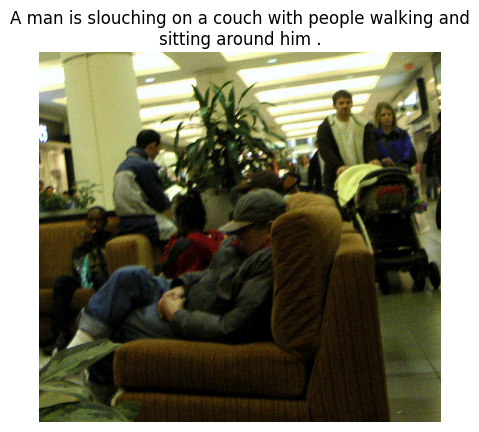

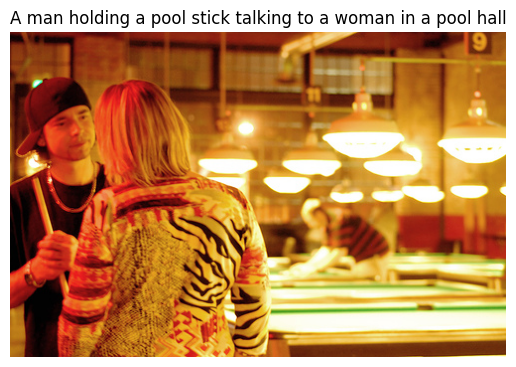

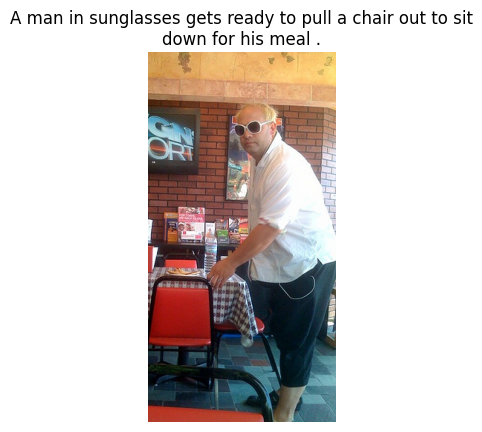

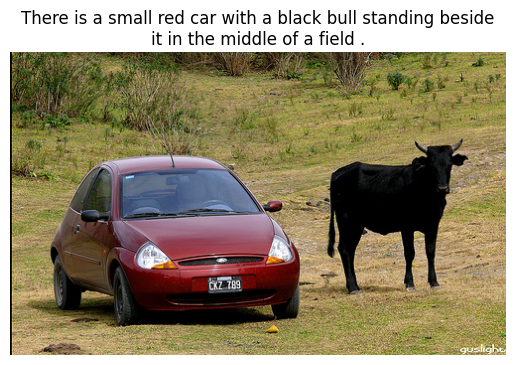

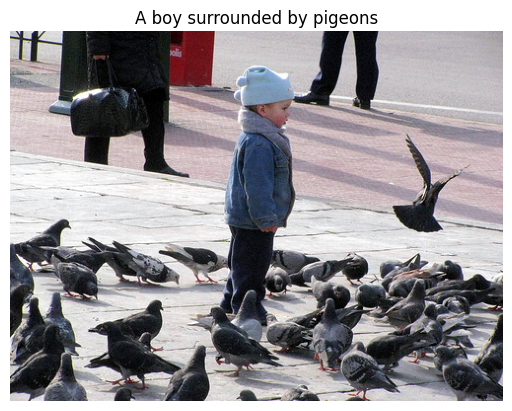

===== flickr30k=====
145000 training samples - 5070 validation samples - 5000 test samples
Total Unique Images: 31014
split
test      1000
train    29000
val       1014
Name: image, dtype: int64


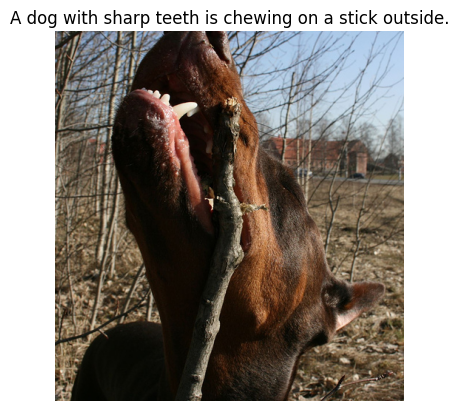

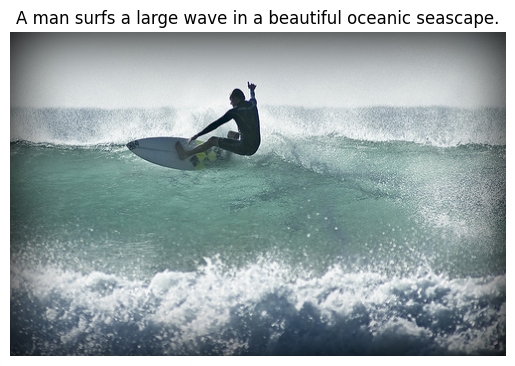

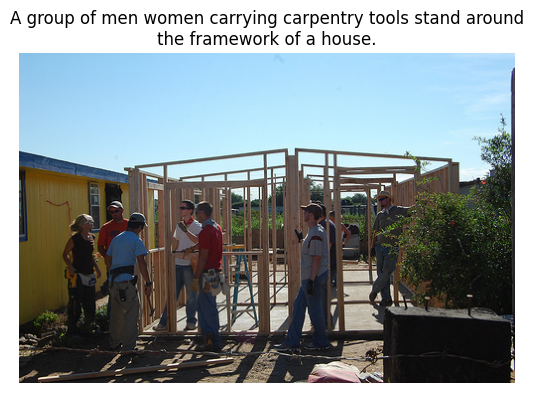

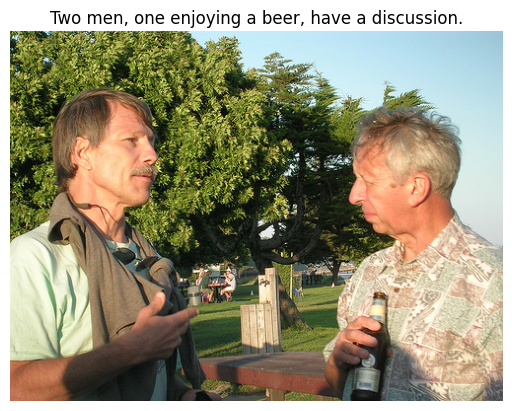

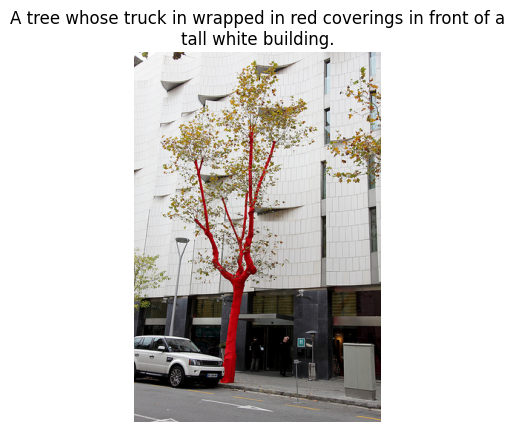

In [4]:
print("===== flickr8k =====")
print(f"{len(flickr8k_df[flickr8k_df['split'] == 'train'].reset_index(drop=True))} training samples - {len(flickr8k_df[flickr8k_df['split'] == 'val'].reset_index(drop=True))} validation samples - {len(flickr8k_df[flickr8k_df['split'] == 'test'].reset_index(drop=True))} test samples")
analyze_image_splits(flickr8k_df)
show_image_with_label(flickr8k_df.sample(
    5), datasets['flickr8k']['img_folder'])

print("===== flickr30k=====")
print(f"{len(flickr30k_df[flickr30k_df['split'] == 'train'].reset_index(drop=True))} training samples - {len(flickr30k_df[flickr30k_df['split'] == 'val'].reset_index(drop=True))} validation samples - {len(flickr30k_df[flickr30k_df['split'] == 'test'].reset_index(drop=True))} test samples")
analyze_image_splits(flickr30k_df)
show_image_with_label(flickr30k_df.sample(
    5), datasets['flickr30k']['img_folder'])

## Baseline Model (ResNet + LSTM)

In [5]:
class EncoderResnet50(nn.Module):
    def __init__(self, encoded_dim=256):
        super().__init__()
        self.resnet = models.resnet50(
            weights=models.ResNet50_Weights.IMAGENET1K_V1)

        # For the frozen Resnet
        for param in self.resnet.parameters():
            param.requires_grad = False

        modules = nn.Sequential(*list(self.resnet.children())[:-1])
        self.backbone = nn.Sequential(*modules)

        self.fc = nn.Linear(self.resnet.fc.in_features, encoded_dim)
        self.bn = nn.BatchNorm1d(encoded_dim)
        self.relu = nn.ReLU()

    def forward(self, images):
        with torch.no_grad():
            features = self.backbone(images)
        features = features.view(features.size(0), -1)
        features = self.relu(self.bn(self.fc(features)))
        return features


class DecoderLSTM(nn.Module):
    def __init__(self, encoder_dim, embed_size, hidden_size, vocab_size, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size + encoder_dim,
                            hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        embeddings = self.embedding(captions)
        img_features = features.unsqueeze(1).repeat(1, embeddings.size(1), 1)
        inputs = torch.cat((img_features, embeddings), dim=2)
        hiddens, _ = self.lstm(inputs)
        outputs = self.linear(hiddens)
        return outputs


class ResNetLSTMCaptioningModel(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs


def load_resnet_lstm_captionning_model(path, model):
    state_dict = torch.load(model_path, map_location=device)
    new_state_dict = {}
    for k, v in state_dict.items():
        name = k.replace("module.", "")
        new_state_dict[name] = v

    model.load_state_dict(new_state_dict)
    model = model.to(device)
    model.eval()

### Training

In [6]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = EncoderResnet50(encoded_dim=256)
decoder = DecoderLSTM(encoder_dim=256, embed_size=256,
                      hidden_size=512, vocab_size=tokenizer.vocab_size)
model = ResNetLSTMCaptioningModel(encoder, decoder)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)
model = model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

Using 4 GPUs


#### flickr8k training

Training on 20 epochs, batch size = 128, num_workers = 4, save_folder = data/flickr8k
Number of training samples: 235
Number of validation samples: 40


Epoch 1/20 - Training: 100%|██████████| 235/235 [01:50<00:00,  2.12it/s]


Epoch 1/20 - Training Loss: 6.0231


Epoch 1/20 - Validation: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]


Epoch 1/20 - Validation Loss: 4.9278
Model saved to data/flickr8k/epoch_1.pth


Epoch 2/20 - Training: 100%|██████████| 235/235 [01:14<00:00,  3.16it/s]


Epoch 2/20 - Training Loss: 4.6311


Epoch 2/20 - Validation: 100%|██████████| 40/40 [00:10<00:00,  3.79it/s]


Epoch 2/20 - Validation Loss: 4.4872
Model saved to data/flickr8k/epoch_2.pth


Epoch 3/20 - Training: 100%|██████████| 235/235 [01:13<00:00,  3.18it/s]


Epoch 3/20 - Training Loss: 4.2554


Epoch 3/20 - Validation: 100%|██████████| 40/40 [00:10<00:00,  3.87it/s]


Epoch 3/20 - Validation Loss: 4.1917
Model saved to data/flickr8k/epoch_3.pth


Epoch 4/20 - Training: 100%|██████████| 235/235 [01:14<00:00,  3.15it/s]


Epoch 4/20 - Training Loss: 3.9853


Epoch 4/20 - Validation: 100%|██████████| 40/40 [00:11<00:00,  3.56it/s]


Epoch 4/20 - Validation Loss: 3.9907
Model saved to data/flickr8k/epoch_4.pth


Epoch 5/20 - Training: 100%|██████████| 235/235 [01:17<00:00,  3.03it/s]


Epoch 5/20 - Training Loss: 3.7811


Epoch 5/20 - Validation: 100%|██████████| 40/40 [00:10<00:00,  3.92it/s]


Epoch 5/20 - Validation Loss: 3.8202
Model saved to data/flickr8k/epoch_5.pth


Epoch 6/20 - Training: 100%|██████████| 235/235 [01:14<00:00,  3.17it/s]


Epoch 6/20 - Training Loss: 3.6195


Epoch 6/20 - Validation: 100%|██████████| 40/40 [00:10<00:00,  3.72it/s]


Epoch 6/20 - Validation Loss: 3.6915
Model saved to data/flickr8k/epoch_6.pth


Epoch 7/20 - Training: 100%|██████████| 235/235 [01:14<00:00,  3.16it/s]


Epoch 7/20 - Training Loss: 3.4839


Epoch 7/20 - Validation: 100%|██████████| 40/40 [00:11<00:00,  3.48it/s]


Epoch 7/20 - Validation Loss: 3.5948
Model saved to data/flickr8k/epoch_7.pth


Epoch 8/20 - Training: 100%|██████████| 235/235 [01:14<00:00,  3.17it/s]


Epoch 8/20 - Training Loss: 3.3672


Epoch 8/20 - Validation: 100%|██████████| 40/40 [00:11<00:00,  3.62it/s]


Epoch 8/20 - Validation Loss: 3.5168
Model saved to data/flickr8k/epoch_8.pth


Epoch 9/20 - Training: 100%|██████████| 235/235 [01:16<00:00,  3.09it/s]


Epoch 9/20 - Training Loss: 3.2666


Epoch 9/20 - Validation: 100%|██████████| 40/40 [00:10<00:00,  3.69it/s]


Epoch 9/20 - Validation Loss: 3.4559
Model saved to data/flickr8k/epoch_9.pth


Epoch 10/20 - Training: 100%|██████████| 235/235 [01:14<00:00,  3.17it/s]


Epoch 10/20 - Training Loss: 3.1750


Epoch 10/20 - Validation: 100%|██████████| 40/40 [00:09<00:00,  4.04it/s]


Epoch 10/20 - Validation Loss: 3.3944
Model saved to data/flickr8k/epoch_10.pth


Epoch 11/20 - Training: 100%|██████████| 235/235 [01:14<00:00,  3.16it/s]


Epoch 11/20 - Training Loss: 3.0940


Epoch 11/20 - Validation: 100%|██████████| 40/40 [00:10<00:00,  3.66it/s]


Epoch 11/20 - Validation Loss: 3.3538
Model saved to data/flickr8k/epoch_11.pth


Epoch 12/20 - Training: 100%|██████████| 235/235 [01:14<00:00,  3.14it/s]


Epoch 12/20 - Training Loss: 3.0204


Epoch 12/20 - Validation: 100%|██████████| 40/40 [00:10<00:00,  3.72it/s]


Epoch 12/20 - Validation Loss: 3.3235
Model saved to data/flickr8k/epoch_12.pth


Epoch 13/20 - Training: 100%|██████████| 235/235 [01:14<00:00,  3.16it/s]


Epoch 13/20 - Training Loss: 2.9537


Epoch 13/20 - Validation: 100%|██████████| 40/40 [00:11<00:00,  3.60it/s]


Epoch 13/20 - Validation Loss: 3.2770
Model saved to data/flickr8k/epoch_13.pth


Epoch 14/20 - Training: 100%|██████████| 235/235 [01:13<00:00,  3.18it/s]


Epoch 14/20 - Training Loss: 2.8931


Epoch 14/20 - Validation: 100%|██████████| 40/40 [00:11<00:00,  3.43it/s]


Epoch 14/20 - Validation Loss: 3.2386
Model saved to data/flickr8k/epoch_14.pth


Epoch 15/20 - Training: 100%|██████████| 235/235 [01:14<00:00,  3.16it/s]


Epoch 15/20 - Training Loss: 2.8346


Epoch 15/20 - Validation: 100%|██████████| 40/40 [00:10<00:00,  3.82it/s]


Epoch 15/20 - Validation Loss: 3.2097
Model saved to data/flickr8k/epoch_15.pth


Epoch 16/20 - Training: 100%|██████████| 235/235 [01:14<00:00,  3.17it/s]


Epoch 16/20 - Training Loss: 2.7816


Epoch 16/20 - Validation: 100%|██████████| 40/40 [00:10<00:00,  3.84it/s]


Epoch 16/20 - Validation Loss: 3.2026
Model saved to data/flickr8k/epoch_16.pth


Epoch 17/20 - Training: 100%|██████████| 235/235 [01:16<00:00,  3.07it/s]


Epoch 17/20 - Training Loss: 2.7318


Epoch 17/20 - Validation: 100%|██████████| 40/40 [00:10<00:00,  3.89it/s]


Epoch 17/20 - Validation Loss: 3.1525
Model saved to data/flickr8k/epoch_17.pth


Epoch 18/20 - Training: 100%|██████████| 235/235 [01:14<00:00,  3.15it/s]


Epoch 18/20 - Training Loss: 2.6846


Epoch 18/20 - Validation: 100%|██████████| 40/40 [00:10<00:00,  3.67it/s]


Epoch 18/20 - Validation Loss: 3.1624


Epoch 19/20 - Training: 100%|██████████| 235/235 [01:14<00:00,  3.18it/s]


Epoch 19/20 - Training Loss: 2.6398


Epoch 19/20 - Validation: 100%|██████████| 40/40 [00:10<00:00,  3.76it/s]


Epoch 19/20 - Validation Loss: 3.1502
Model saved to data/flickr8k/epoch_19.pth


Epoch 20/20 - Training: 100%|██████████| 235/235 [01:13<00:00,  3.18it/s]


Epoch 20/20 - Training Loss: 2.5969


Epoch 20/20 - Validation: 100%|██████████| 40/40 [00:10<00:00,  3.65it/s]


Epoch 20/20 - Validation Loss: 3.1216
Model saved to data/flickr8k/epoch_20.pth


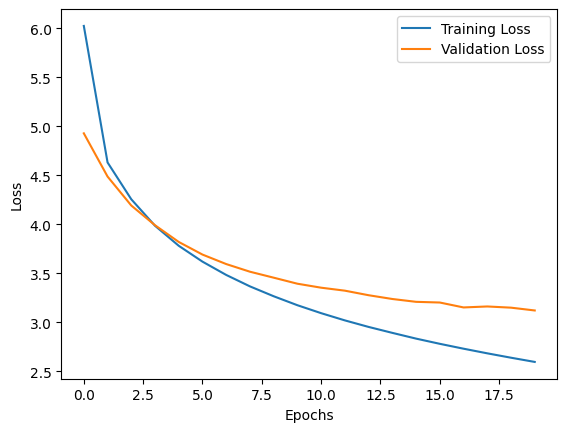

In [9]:
array_loss_train, array_loss_valid = train(
    flickr8k_df, datasets['flickr8k']['img_folder'], datasets['flickr8k']['folder'], model, tokenizer, optimizer, criterion, device)

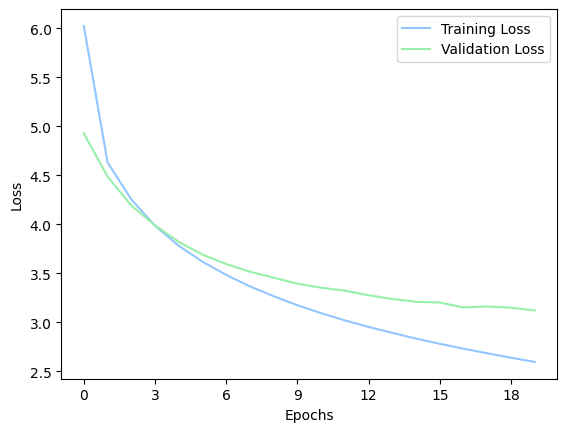

In [21]:
plt.style.use("seaborn-v0_8-pastel")
plt.plot(array_loss_train, label='Training Loss')
plt.plot(array_loss_valid, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

#### flickr30k training

In [22]:
array_loss_train_30k, array_loss_valid_30k = train(
    flickr30k_df, datasets['flickr30k']['img_folder'], datasets['flickr30k']['folder'], model, tokenizer, optimizer, criterion, device)

Training on 20 epochs, batch size = 128, num_workers = 4, save_folder = data/flickr30k
Number of training samples: 1133
Number of validation samples: 40


Epoch 1/20 - Training: 100%|██████████| 1133/1133 [06:35<00:00,  2.86it/s]


Epoch 1/20 - Training Loss: 3.4486


Epoch 1/20 - Validation: 100%|██████████| 40/40 [00:13<00:00,  3.01it/s]


Epoch 1/20 - Validation Loss: 3.3541
Model saved to data/flickr30k/epoch_1.pth


Epoch 2/20 - Training: 100%|██████████| 1133/1133 [05:57<00:00,  3.17it/s]


Epoch 2/20 - Training Loss: 3.2415


Epoch 2/20 - Validation: 100%|██████████| 40/40 [00:10<00:00,  3.82it/s]


Epoch 2/20 - Validation Loss: 3.2424
Model saved to data/flickr30k/epoch_2.pth


Epoch 3/20 - Training: 100%|██████████| 1133/1133 [06:03<00:00,  3.12it/s]


Epoch 3/20 - Training Loss: 3.1184


Epoch 3/20 - Validation: 100%|██████████| 40/40 [00:10<00:00,  3.74it/s]


Epoch 3/20 - Validation Loss: 3.1674
Model saved to data/flickr30k/epoch_3.pth


Epoch 4/20 - Training: 100%|██████████| 1133/1133 [05:56<00:00,  3.18it/s]


Epoch 4/20 - Training Loss: 3.0237


Epoch 4/20 - Validation: 100%|██████████| 40/40 [00:10<00:00,  3.85it/s]


Epoch 4/20 - Validation Loss: 3.1102
Model saved to data/flickr30k/epoch_4.pth


Epoch 5/20 - Training: 100%|██████████| 1133/1133 [06:04<00:00,  3.11it/s]


Epoch 5/20 - Training Loss: 2.9455


Epoch 5/20 - Validation: 100%|██████████| 40/40 [00:10<00:00,  3.92it/s]


Epoch 5/20 - Validation Loss: 3.0668
Model saved to data/flickr30k/epoch_5.pth


Epoch 6/20 - Training: 100%|██████████| 1133/1133 [06:07<00:00,  3.08it/s]


Epoch 6/20 - Training Loss: 2.8790


Epoch 6/20 - Validation: 100%|██████████| 40/40 [00:10<00:00,  3.66it/s]


Epoch 6/20 - Validation Loss: 3.0313
Model saved to data/flickr30k/epoch_6.pth


Epoch 7/20 - Training: 100%|██████████| 1133/1133 [05:57<00:00,  3.17it/s]


Epoch 7/20 - Training Loss: 2.8206


Epoch 7/20 - Validation: 100%|██████████| 40/40 [00:10<00:00,  3.92it/s]


Epoch 7/20 - Validation Loss: 3.0074
Model saved to data/flickr30k/epoch_7.pth


Epoch 8/20 - Training: 100%|██████████| 1133/1133 [05:58<00:00,  3.16it/s]


Epoch 8/20 - Training Loss: 2.7692


Epoch 8/20 - Validation: 100%|██████████| 40/40 [00:10<00:00,  3.87it/s]


Epoch 8/20 - Validation Loss: 2.9772
Model saved to data/flickr30k/epoch_8.pth


Epoch 9/20 - Training: 100%|██████████| 1133/1133 [05:56<00:00,  3.18it/s]


Epoch 9/20 - Training Loss: 2.7225


Epoch 9/20 - Validation: 100%|██████████| 40/40 [00:10<00:00,  3.85it/s]


Epoch 9/20 - Validation Loss: 2.9590
Model saved to data/flickr30k/epoch_9.pth


Epoch 10/20 - Training: 100%|██████████| 1133/1133 [05:55<00:00,  3.19it/s]


Epoch 10/20 - Training Loss: 2.6805


Epoch 10/20 - Validation: 100%|██████████| 40/40 [00:10<00:00,  3.99it/s]


Epoch 10/20 - Validation Loss: 2.9389
Model saved to data/flickr30k/epoch_10.pth


Epoch 11/20 - Training: 100%|██████████| 1133/1133 [06:00<00:00,  3.14it/s]


Epoch 11/20 - Training Loss: 2.6411


Epoch 11/20 - Validation: 100%|██████████| 40/40 [00:10<00:00,  3.72it/s]


Epoch 11/20 - Validation Loss: 2.9252
Model saved to data/flickr30k/epoch_11.pth


Epoch 12/20 - Training: 100%|██████████| 1133/1133 [05:59<00:00,  3.15it/s]


Epoch 12/20 - Training Loss: 2.6051


Epoch 12/20 - Validation: 100%|██████████| 40/40 [00:10<00:00,  3.74it/s]


Epoch 12/20 - Validation Loss: 2.9136
Model saved to data/flickr30k/epoch_12.pth


Epoch 13/20 - Training: 100%|██████████| 1133/1133 [06:00<00:00,  3.14it/s]


Epoch 13/20 - Training Loss: 2.5710


Epoch 13/20 - Validation: 100%|██████████| 40/40 [00:11<00:00,  3.57it/s]


Epoch 13/20 - Validation Loss: 2.9065
Model saved to data/flickr30k/epoch_13.pth


Epoch 14/20 - Training: 100%|██████████| 1133/1133 [05:56<00:00,  3.18it/s]


Epoch 14/20 - Training Loss: 2.5396


Epoch 14/20 - Validation: 100%|██████████| 40/40 [00:10<00:00,  3.82it/s]


Epoch 14/20 - Validation Loss: 2.8998
Model saved to data/flickr30k/epoch_14.pth


Epoch 15/20 - Training: 100%|██████████| 1133/1133 [05:57<00:00,  3.17it/s]


Epoch 15/20 - Training Loss: 2.5104


Epoch 15/20 - Validation: 100%|██████████| 40/40 [00:11<00:00,  3.40it/s]


Epoch 15/20 - Validation Loss: 2.8870
Model saved to data/flickr30k/epoch_15.pth


Epoch 16/20 - Training: 100%|██████████| 1133/1133 [05:55<00:00,  3.18it/s]


Epoch 16/20 - Training Loss: 2.4824


Epoch 16/20 - Validation: 100%|██████████| 40/40 [00:10<00:00,  3.74it/s]


Epoch 16/20 - Validation Loss: 2.8823
Model saved to data/flickr30k/epoch_16.pth


Epoch 17/20 - Training: 100%|██████████| 1133/1133 [05:57<00:00,  3.17it/s]


Epoch 17/20 - Training Loss: 2.4554


Epoch 17/20 - Validation: 100%|██████████| 40/40 [00:10<00:00,  3.92it/s]


Epoch 17/20 - Validation Loss: 2.8759
Model saved to data/flickr30k/epoch_17.pth


Epoch 18/20 - Training: 100%|██████████| 1133/1133 [06:04<00:00,  3.11it/s]


Epoch 18/20 - Training Loss: 2.4299


Epoch 18/20 - Validation: 100%|██████████| 40/40 [00:10<00:00,  3.74it/s]


Epoch 18/20 - Validation Loss: 2.8728
Model saved to data/flickr30k/epoch_18.pth


Epoch 19/20 - Training: 100%|██████████| 1133/1133 [06:03<00:00,  3.12it/s]


Epoch 19/20 - Training Loss: 2.4056


Epoch 19/20 - Validation: 100%|██████████| 40/40 [00:10<00:00,  3.84it/s]


Epoch 19/20 - Validation Loss: 2.8715
Model saved to data/flickr30k/epoch_19.pth


Epoch 20/20 - Training: 100%|██████████| 1133/1133 [05:56<00:00,  3.18it/s]


Epoch 20/20 - Training Loss: 2.3824


Epoch 20/20 - Validation: 100%|██████████| 40/40 [00:10<00:00,  3.67it/s]


Epoch 20/20 - Validation Loss: 2.8657
Model saved to data/flickr30k/epoch_20.pth


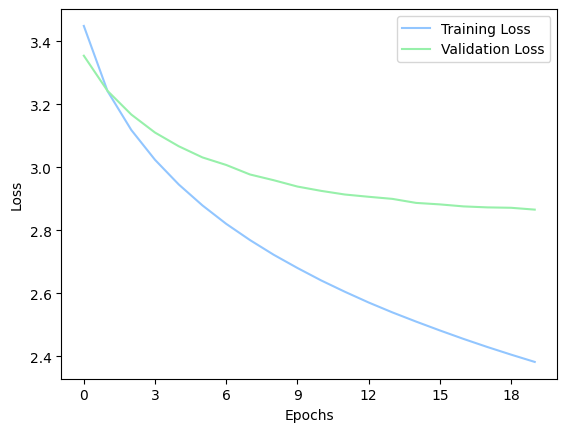

In [24]:
plt.style.use("seaborn-v0_8-pastel")
plt.plot(array_loss_train_30k, label='Training Loss')
plt.plot(array_loss_valid_30k, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

### Qualitative evaluation

In [7]:
def generate_caption(image_path, model, tokenizer, max_length=30, device=device):
    model.eval()
    if isinstance(model, nn.DataParallel):
        encoder = model.module.encoder
        decoder = model.module.decoder
    else:
        encoder = model.encoder
        decoder = model.decoder

    image = load_image(image_path)
    image = image_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        img_features = encoder(image)

        input_ids = torch.tensor(
            [[tokenizer.cls_token_id]], dtype=torch.long).to(device)

        generated_ids = []

        for _ in range(max_length):

            outputs = decoder(img_features, input_ids)
            logits = outputs[:, -1, :]
            predicted_id = logits.argmax(dim=1).unsqueeze(1)

            if predicted_id.item() == tokenizer.sep_token_id:
                break
            generated_ids.append(predicted_id.item())
            input_ids = torch.cat([input_ids, predicted_id], dim=1)

    caption = tokenizer.decode(generated_ids, skip_special_tokens=True)
    return caption

#### flickr8k evaluation

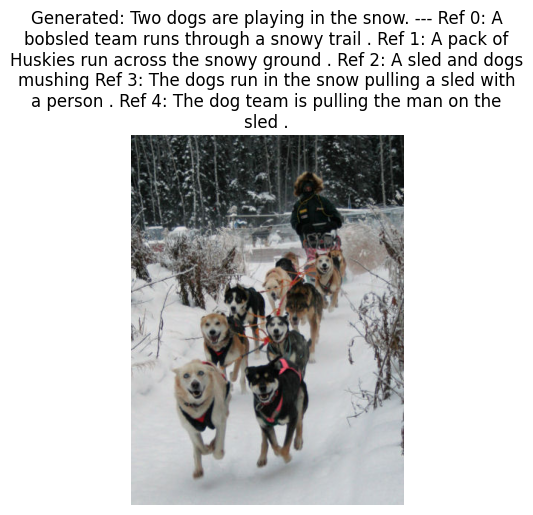

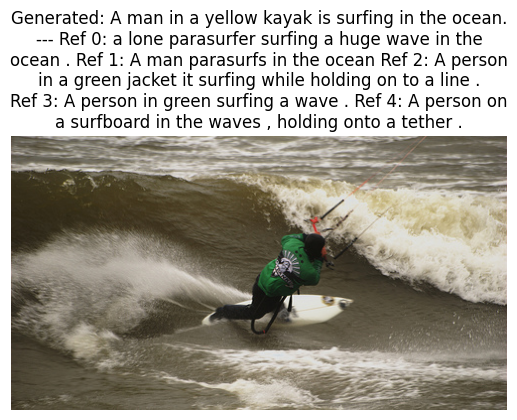

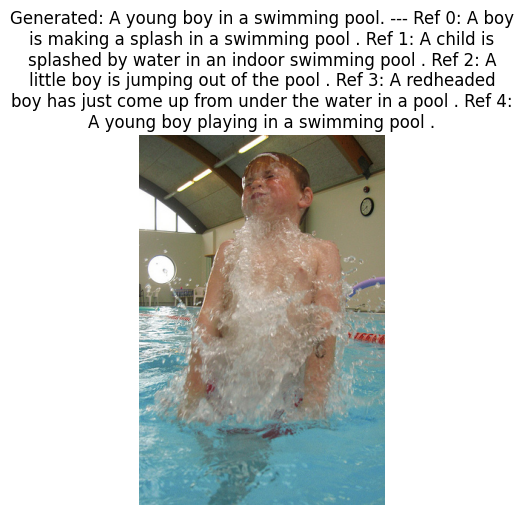

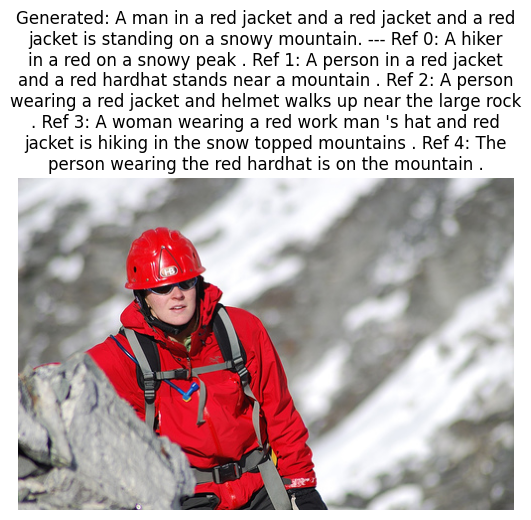

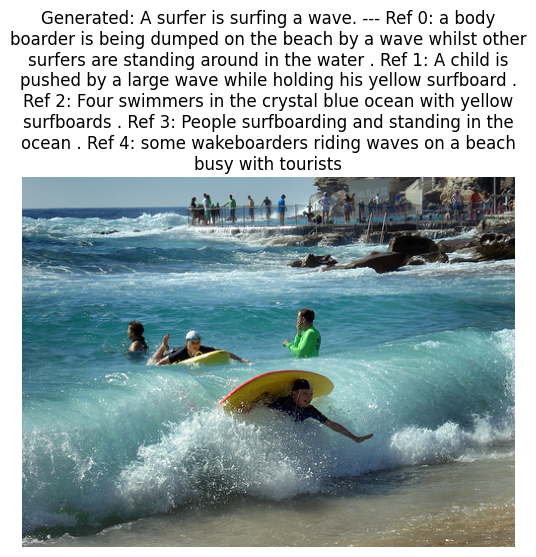

In [8]:
model_path = os.path.join(datasets['flickr8k']['folder'], 'epoch_20.pth')
model = ResNetLSTMCaptioningModel(encoder, decoder)
load_resnet_lstm_captionning_model(model_path, model)

test_data8k = flickr8k_df[flickr8k_df['split']
                          == 'test'].reset_index(drop=True)
# unique_images = test_data8k['image'].drop_duplicates().sample(5)
unique_images = ["3113322995_13781860f2.jpg", "3044536048_e615466e7f.jpg",
                 "2660008870_b672a4c76a.jpg", "416960865_048fd3f294.jpg", "1998457059_c9ac9a1e1a.jpg"]

for image_name in unique_images:
    refs = test_data8k[test_data8k['image'] == image_name]['caption'].tolist()

    image_path = os.path.join(datasets['flickr8k']['img_folder'], image_name)
    generated_caption = generate_caption(
        image_path, model, tokenizer, max_length=30, device=device)
    image = load_image(image_path)
    refs_str = "\n".join([f"Ref {i}: {c}" for i, c in enumerate(refs)])
    show_image(image, title=f"Generated: {generated_caption}\n---\n{refs_str}")

#### flickr30k evaluation

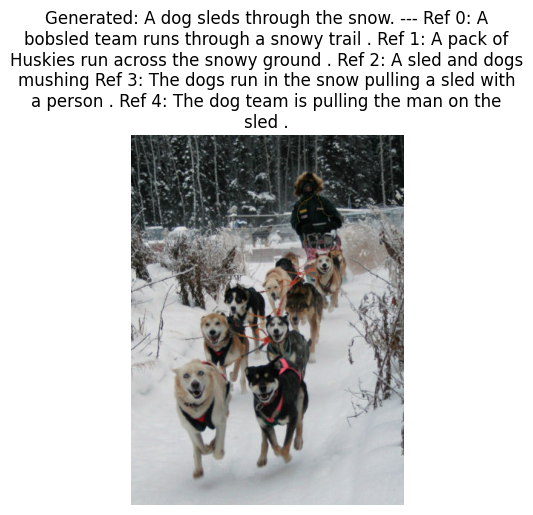

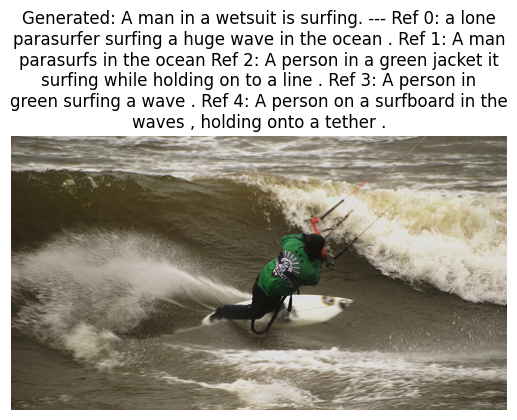

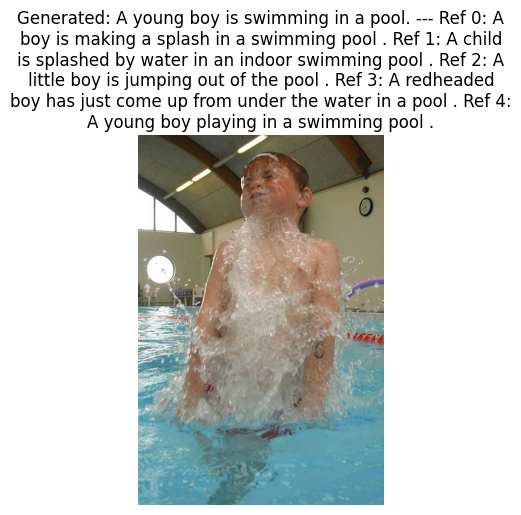

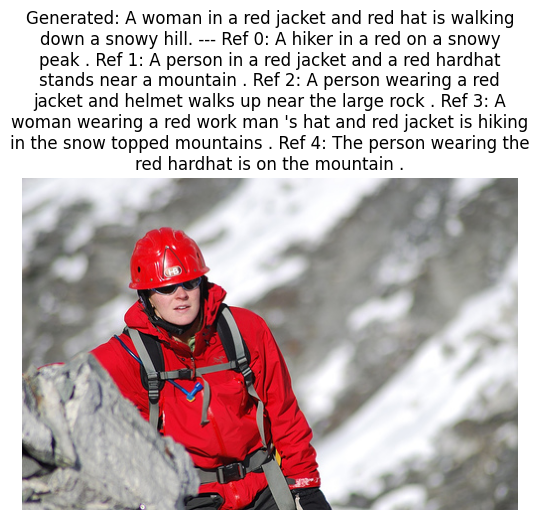

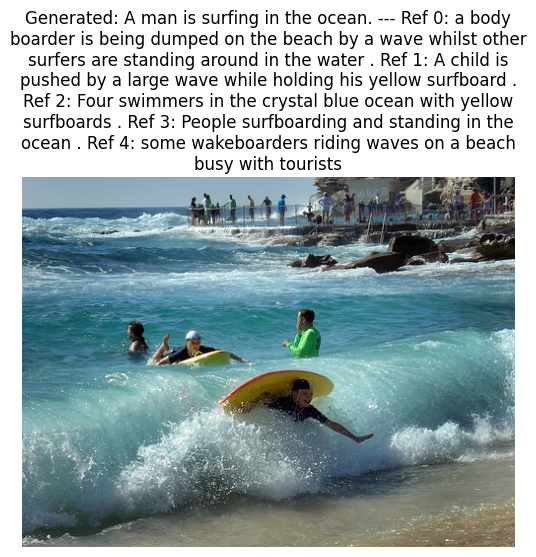

In [9]:
model_path = os.path.join(datasets['flickr30k']['folder'], 'epoch_20.pth')
model = ResNetLSTMCaptioningModel(encoder, decoder)
load_resnet_lstm_captionning_model(model_path, model)
# On flickr8k dataset same test images voluntarily
for image_name in unique_images:
    refs = test_data8k[test_data8k['image'] == image_name]['caption'].tolist()

    image_path = os.path.join(datasets['flickr8k']['img_folder'], image_name)
    generated_caption = generate_caption(
        image_path, model, tokenizer, max_length=30, device=device)
    image = load_image(image_path)
    refs_str = "\n".join([f"Ref {i}: {c}" for i, c in enumerate(refs)])
    show_image(image, title=f"Generated: {generated_caption}\n---\n{refs_str}")

### Quantitative evaluation

#### flickr8k evaluation

In [ ]:
# TODO, eval over entire datasets with BLEU or other metrics

#### flickr30k evaluation

In [ ]:
# TODO, eval over entire datasets with BLEU or other metrics

### Enhanced Model

In [ ]:
class EncoderVisionTransformer(nn.Module):
    def __init__(self, encoded_dim=256):
        super().__init__()
        self.vit = models.vit_b_16(
            weights=models.ViT_B_16_Weights.IMAGENET1K_V1)

        # For the frozen ViT
        for param in self.vit.parameters():
            param.requires_grad = False

        modules = nn.Sequential(*list(self.vit.children())[:-1])
        self.backbone = nn.Sequential(*modules)

        self.fc = nn.Linear(self.vit.heads.head.in_features, encoded_dim)
        self.bn = nn.BatchNorm1d(encoded_dim)
        self.relu = nn.ReLU()

    def forward(self, images):
        with torch.no_grad():
            features = self.backbone(images)
        features = features.view(features.size(0), -1)
        features = self.relu(self.bn(self.fc(features)))
        return features


class DecoderTransformer(nn.Module):
    def __init__(self, encoder_dim, embed_size, num_heads, hidden_size, vocab_size, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.positional_encoding = nn.Parameter(
            torch.zeros(1, 500, embed_size))
        transformer_layer = nn.TransformerDecoderLayer(
            d_model=embed_size + encoder_dim, nhead=num_heads, dim_feedforward=hidden_size)
        self.transformer_decoder = nn.TransformerDecoder(
            transformer_layer, num_layers=num_layers)
        self.linear = nn.Linear(embed_size + encoder_dim, vocab_size)

    def forward(self, features, captions):
        embeddings = self.embedding(captions)
        embeddings = embeddings + \
            self.positional_encoding[:, :embeddings.size(1), :]

        img_features = features.unsqueeze(1).repeat(1, embeddings.size(1), 1)
        inputs = torch.cat((img_features, embeddings), dim=2)

        inputs = inputs.permute(1, 0, 2)
        memory = img_features.permute(1, 0, 2)

        hiddens = self.transformer_decoder(inputs, memory)
        hiddens = hiddens.permute(1, 0, 2)

        outputs = self.linear(hiddens)
        return outputs


Encoder = EncoderVisionTransformer(encoded_dim=256).to(device)
Decoder = DecoderTransformer(encoder_dim=256, embed_size=256, num_heads=8,
                             hidden_size=512, vocab_size=tokenizer.vocab_size, num_layers=2).to(device)